# Принятие решений в бизнесе

Интернет-магазин предоставил список гипотез для учеличения прибыли, разработанный совместно с отделом маркетинга. 

Наша задача:
- приоритизация гипотез
- запкстить А/В-тест
- анализ результатов.



**План работы:**
* предобработка данных
* приоритизация гипотез
* А/В-тест

## Предобрабтка даных

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import datetime as dt
import scipy.stats as stats
import warnings

In [2]:
# снимаем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

In [3]:
# читаем файлы
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [4]:
display(hypothesis)
display(orders)
display(visitors)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [5]:
display(hypothesis.info())
display(orders.info())
display(visitors.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

In [6]:
# проверяем таблицы на наличие дубликатов
display(visitors.duplicated().sum())
display(orders.duplicated().sum())

0

0

Ознакомились с данными. Есть с чем работать. Для начала столбцы с датами в orders и visitors приведем к типу datetime, а названия столбцов приведем к единому стилю для удобства работы. Пропусков и дубликатов нет.

In [7]:
# меняем название столбцов и приведем в нижний регистр
hypothesis.columns = hypothesis.columns.str.lower()
orders = orders.rename(columns={'transactionId':'transaction_id', 'visitorId':'visitor_id'})

In [8]:
# перезапишем формат даты
visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])

Данные приведены в порядок и готовы к анализу.

Проверим, не попадают ли какие-то пользователи в обе группы - по таблице с заказами.

In [9]:
# список уникальных пользователей
users = orders['visitor_id'].unique()

# проверка наличия пользователей в обеих группах
users_in_both_groups = []
for user in users:
    group_a_orders = orders[(orders['visitor_id'] == user) & (orders['group'] == 'A')]
    group_b_orders = orders[(orders['visitor_id'] == user) & (orders['group'] == 'B')]
    if len(group_a_orders) > 0 and len(group_b_orders) > 0:
        users_in_both_groups.append(user)

# вывод результатов
if len(users_in_both_groups) > 0:
    print("Следующие пользователи попадают в обе группы:")
    for user in users_in_both_groups:
        print(user)
else:
    print("Нет пользователей, попадающих в обе группы.")

Следующие пользователи попадают в обе группы:
4069496402
963407295
351125977
3234906277
199603092
237748145
3803269165
2038680547
2378935119
4256040402
2712142231
8300375
276558944
457167155
3062433592
1738359350
2458001652
2716752286
3891541246
1648269707
3656415546
2686716486
2954449915
2927087541
2579882178
3957174400
2780786433
3984495233
818047933
1668030113
3717692402
2044997962
1959144690
1294878855
1404934699
2587333274
3202540741
1333886533
2600415354
3951559397
393266494
3972127743
4120364173
4266935830
1230306981
1614305549
477780734
1602967004
1801183820
4186807279
3766097110
3941795274
471551937
1316129916
232979603
2654030115
3963646447
2949041841


Ползователей которые попали в обе группы, достаточно. 

## Приоритизация гипотез

Задачи:
1. Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
2. Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
3. Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE. 

### Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.

In [10]:
hypothesis['ice'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(1)
hypothesis.sort_values('ice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0


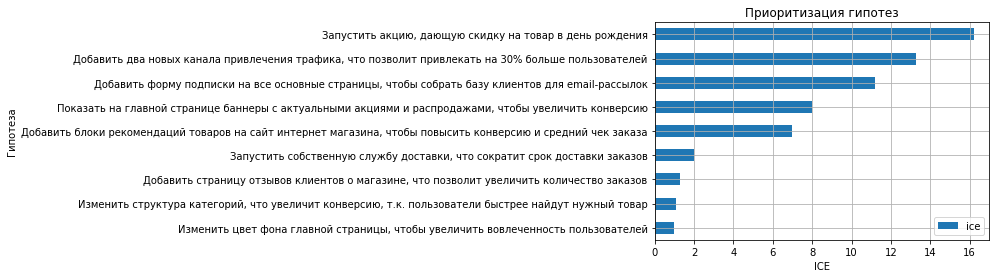

In [11]:
# создание графика
hypothesis.sort_values('ice', ascending=True).plot(x='hypothesis', y='ice', kind='barh', grid=True)
plt.xlabel('ICE')
plt.ylabel('Гипотеза')
plt.title('Приоритизация гипотез')
plt.show()

Топ 3 гипотез по ICE:
1. Запустить акцию, дающую скидку на товар в день рождения	
2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
3. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

### Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.

In [12]:
hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis.sort_values('rice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0


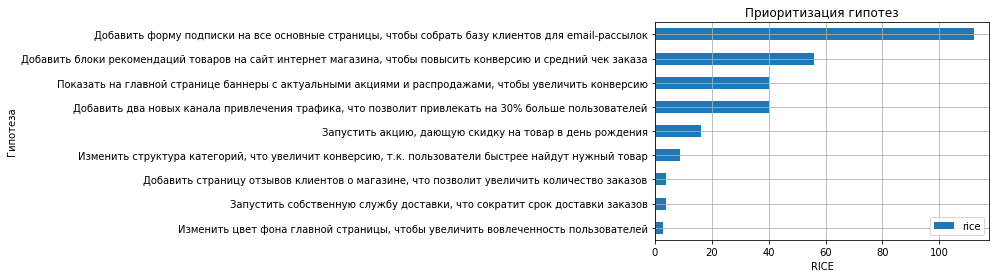

In [13]:
# создание графика
hypothesis.sort_values('rice', ascending=True).plot(x='hypothesis', y='rice', kind='barh', grid=True)
plt.xlabel('RICE')
plt.ylabel('Гипотеза')
plt.title('Приоритизация гипотез')
plt.show()

Топ 3 гипотез по RICE:
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить среднее кол-во заказов на посетителя и средний чек заказа
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

### Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE.

In [14]:
# выводим 2 раза таблицу с сортировкой по одному из фреймворков
display(hypothesis[['hypothesis','ice', 'rice']].sort_values(by='ice', ascending=False))
display(hypothesis[['hypothesis','ice', 'rice']].sort_values(by='rice', ascending=False))

,hypothesis,ice,rice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2,112.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0,40.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0,56.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3,4.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0,3.0


,hypothesis,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0,3.0


**Вывод**

Формула ICE и RICE отличается одним параметром.

ICE - фокусируется на оценке влияния, уверенности и усилий, не учитывая охват. В то время как RICE - учитывает дополнительный фактор "Reach" (охват). Он помогает оценить, сколько пользователей или клиентов затронет гипотеза. И если параметр "Reach" у гипотезы большой, то и RICE будет выше соответственно.

## A/B-тесты

1. Построить график кумулятивной выручки по группам. 
2. Построить график кумулятивного среднего чека по группам. 
3. Построить график относительного изменения кумулятивного среднего чека группы B к группе A. 
4. Построить график кумулятивного среднего количества заказов на посетителя по группам. 
5. Построить график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 
6. Построить точечный график количества заказов по пользователям. 
7. Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей.
8. Построить точечный график стоимостей заказов. 
9. Посчитать 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов.
10. Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.
11. Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 
12. Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 
13. Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 
14. Принять решение по результатам теста и объясните его. Варианты решений:
    1. Остановить тест, зафиксировать победу одной из групп.
    2. Остановить тест, зафиксировать отсутствие различий между группами.
    3. Продолжить тест.

Для создания графиков на основе кумулятивных данных необходимо создать таблицу, которая будет содержать информацию о дате, группе (A или B), накопленном количестве заказов и пользователей, среднем чеке и общем количестве посетителей магазина.

In [15]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

In [16]:
# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
    .agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}),\
    axis=1).sort_values(by=['date','group'])

In [17]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
    .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [18]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Проверим, корректно ли был создан датафрейм cumulativeData. Совпадают ли минимальная и максимальная даты в этом датафрейме с минимальной и максимальной датой в исходных данных.

In [19]:
display(cumulativeData['date'].min())
display(cumulativeData['date'].max())

Timestamp('2019-08-01 00:00:00')

Timestamp('2019-08-31 00:00:00')

In [20]:
display(visitors['date'].min())
display(visitors['date'].max())

Timestamp('2019-08-01 00:00:00')

Timestamp('2019-08-31 00:00:00')

Даты совпадают.


### Построим график кумулятивной выручки по группам.

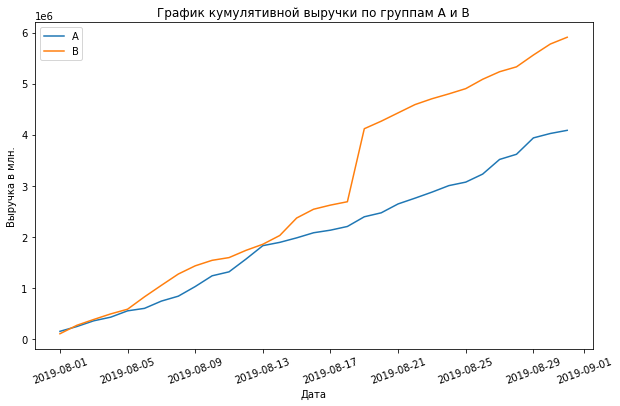

In [21]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# создание графика
plt.figure(figsize=(10, 6))

# Строим график выручки группы А и В
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('График кумулятивной выручки по группам А и В')
plt.ylabel('Выручка в млн.')
plt.xlabel('Дата')
plt.xticks(rotation=20)
plt.legend() 
plt.show()

Видим, что кумулятивная выручка группы А показывает линейный рост, но меньше, чем у группы В. А в группе В есть резкий скачок примерно 18-19 августа, что может быть связано с резким ростом количества заказов либо с появлением очень дорогих заказов в выборке.

### Построим график кумулятивного среднего чека по группам.

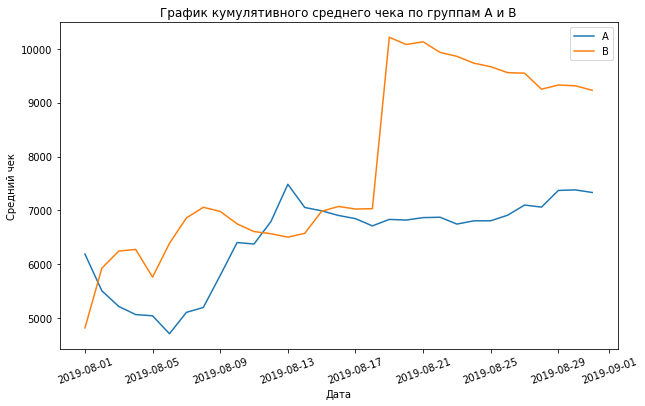

In [22]:
# создание графика
plt.figure(figsize=(10, 6))

# Строим график выручки группы А и В
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.title('График кумулятивного среднего чека по группам А и В')
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.xticks(rotation=20)
plt.legend() 
plt.show()

После 13 августа средний чек в группе А стабилизировался. А скачок в группе В, о котором уже говорили, может и быть вызван тем самым "жирным" заказом.

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

Построим график относительного различия для среднего чека. Добавим горизонтальную ось методом axhline() 

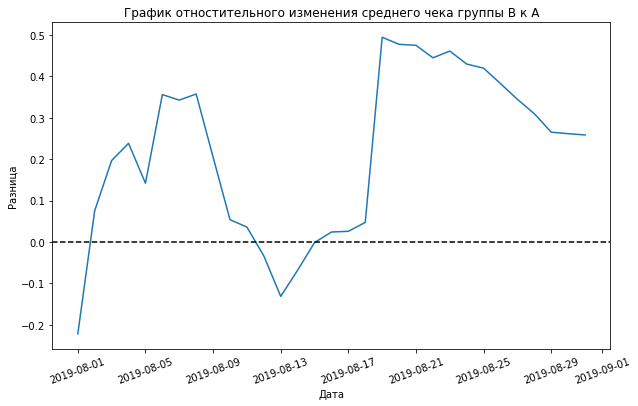

In [23]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(10, 6))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])\
         /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График отностительного изменения среднего чека группы В к А')
plt.ylabel('Разница')
plt.xlabel('Дата')
plt.xticks(rotation=20)
plt.show()

 В нескольких точках видны скачки. Возможно, это и есть те самые крупные заказы или выбросы.

### Построим график кумулятивного среднего количества заказов на посетителя по группам.

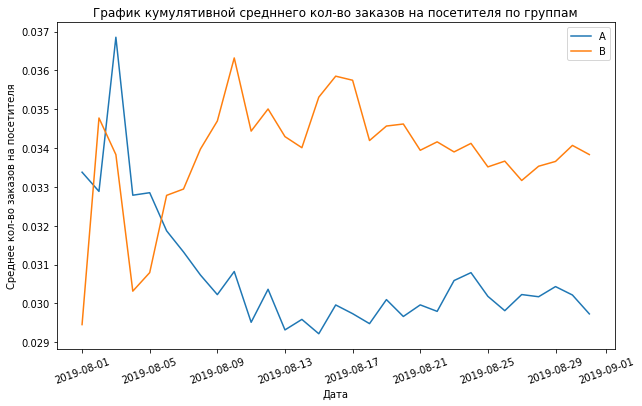

In [24]:
# считаем кумулятивную среднее кол-во заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(10, 6))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('График кумулятивной средннего кол-во заказов на посетителя по группам')
plt.ylabel('Среднее кол-во заказов на посетителя')
plt.xlabel('Дата')
plt.xticks(rotation=20)
plt.legend()
plt.show()

Хаотичные скачки и спады видны в обеих группах до 5 августа. Дальше среднее количество заказов у группы В снова увеличилось, а у группы А показатели снизились.

### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

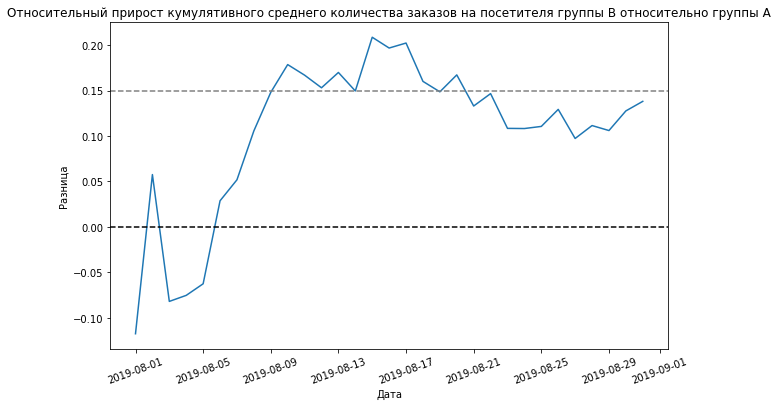

In [25]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']]\
.merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# создаем график
plt.figure(figsize=(10, 6))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']\
         /mergedCumulativeConversions['conversionA']-1)
plt.title("Относительный прирост кумулятивного среднего количества заказов на посетителя группы B относительно группы A")
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.ylabel('Разница')
plt.xlabel('Дата')
plt.xticks(rotation=20)
plt.show()

В начале теста группа В уступала группе А. После этого наблюдаем резкий скачок 2 августа, но 3го числа показатели снова упали. Далее группа В начинает показывать рост и стабильность.

### Построим точечный график количества заказов по пользователям.

count    1031.000000
mean        1.161009
std         0.724919
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        11.000000
Name: orders, dtype: float64

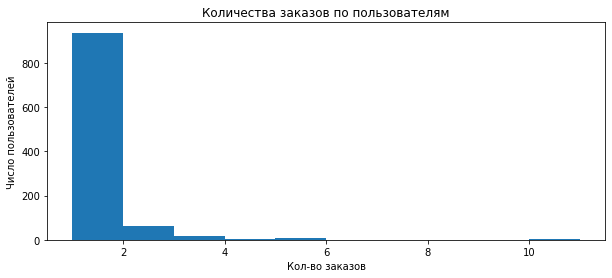

In [26]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns =  ['visitor_id', 'orders']
display(ordersByUsers['orders'].describe())

# строим гистограмму
plt.figure(figsize=(10, 4))
plt.hist(ordersByUsers['orders']) 
plt.title('Количества заказов по пользователям')
plt.xlabel('Кол-во заказов')
plt.ylabel('Число пользователей')
plt.show()

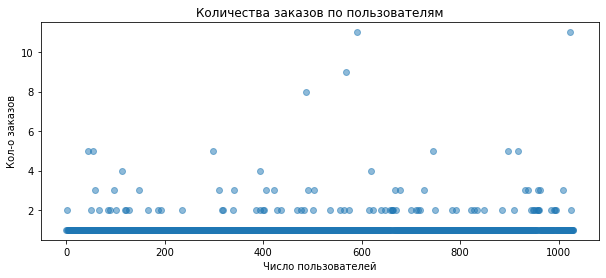

In [27]:
x_values = pd.Series(range(0,len(ordersByUsers)))

# строим точечную диаграмму
plt.figure(figsize=(10, 4))
plt.scatter(x_values, ordersByUsers['orders'], alpha=0.5)
plt.xlabel('Число пользователей')
plt.ylabel('Кол-о заказов')
plt.title('Количества заказов по пользователям');
plt.show()

Большинство покупателей заказывали только один раз. Однако доля пользователей с 2-4 заказами также значительна. Также есть те, кто успел сделать 11 заказов за месяц.

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

In [28]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

Не более 5% пользователей совершали больше двух покупок, а только 1% делали четыре и более покупок.

Граница для определения аномальных пользователей составляет четыре заказа.

### Построим точечный график стоимостей заказов.

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64

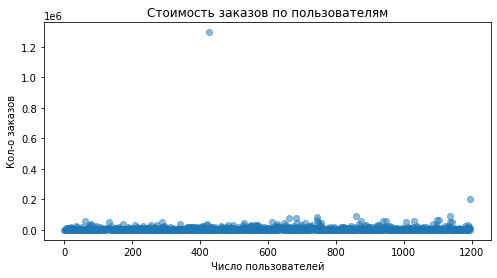

In [29]:
display(orders['revenue'].describe())

x_values = pd.Series(range(0,len(orders)))

# строим точечную диаграмму
plt.figure(figsize=(8, 4))
plt.scatter(x_values, orders['revenue'], alpha=0.5)
plt.xlabel('Число пользователей')
plt.ylabel('Кол-о заказов')
plt.title('Стоимость заказов по пользователям');
plt.show()

Есть выброс(ы), придадим масштаб графику и посмотрим поближе. 

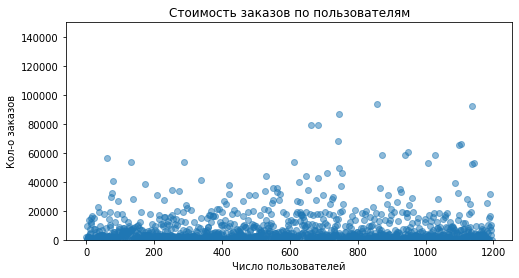

In [30]:
plt.figure(figsize=(8, 4))
plt.ylim(0, 150000)
plt.scatter(x_values, orders['revenue'], alpha=0.5)
plt.xlabel('Число пользователей')
plt.ylabel('Кол-о заказов')
plt.title('Стоимость заказов по пользователям');
plt.show()

Большинство заказов в пределах 20к. 

### Посчитаем 95-й и 99-й перцентили стоимости заказов.

In [31]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Граница для определения аномальных заказов - 58233.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Введем основную и альтернативные гипотезы:

* Н0 - Статистически значимых различий в среднем количестве заказов между группами по сырым данным нет
* Н1 - Статистически значимых различий в среднем количестве заказов между группами по сырым данным есть
 
Уровень значимости: 0,05

In [32]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

ordersACummulative.columns = ['date','ordersCummulativeA','revenueCummulativeA']

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

ordersBCummulative.columns = ['date','ordersCummulativeB','revenueCummulativeB']


data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Напомним названия столбцов данных:

* `date` — дата;
* `ordersPerDateA` — количество заказов в выбранную дату в группе A;
* `revenuePerDateA` — суммарная выручка в выбранную дату в группе A;
* `ordersPerDateB` — количество заказов в выбранную дату в группе B;
* `revenuePerDateB` — суммарная выручка в выбранную дату в группе B;
* `ordersCummulativeA` — суммарное число заказов до выбранной даты включительно в группе A;
* `revenueCummulativeA` — суммарная выручка до выбранной даты включительно в группе A;
* `ordersCummulativeB` — суммарное количество заказов до выбранной даты включительно в группе B;
* `revenueCummulativeB` — суммарная выручка до выбранной даты включительно в группе B;
* `visitorsPerDateA` — количество пользователей в выбранную дату в группе A;
* `visitorsPerDateB` — количество пользователей в выбранную дату в группе B;
* `visitorsCummulativeA` — количество пользователей до выбранной даты включительно в группе A;
* `visitorsCummulativeB` — количество пользователей до выбранной даты включительно в группе B.

Посчитаем статистическую значимость различия в среднем количестве заказов между группами.

Создадим переменные **ordersByUsersA** и **ordersByUsersB**. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. 

In [33]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

Объявим переменные sampleA и sampleB, в которых будут содержаться количество заказов для пользователей из разных групп. Если пользователь ничего не заказал, ему будет соответствовать значение нуля. Это необходимо для подготовки выборок к проверке с использованием критерия Манна-Уитни.

In [34]:
sampleA = pd.concat(
    [ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA']\
                                                           .sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat(
    [ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB']\
                                                           .sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)


alpha = 0.05 
results = stats.mannwhitneyu(sampleA, sampleB)


print('p-значение: ', "{0:.3f}".format(results.pvalue))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

print('Относительный выигрыш группы B:', "{0:.1%}".format(sampleB.mean() / sampleA.mean() - 1))

p-значение:  0.017
Отвергаем нулевую гипотезу
Относительный выигрыш группы B: 13.8%


p-value = 0.017, что меньше 0.05. Значит, мы отвергаем нулевую гипотезу о отсутствии статистически значимых различий в среднем числе заказов между группами. Относительный выигрыш группы B составляет 13.8%.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 

* Н0 - Статистически значимых различий в среднем чеке между группами нет. 
* Н1 - Статистически значимых различия в среднем чеке между группами есть. 

Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов. 

In [35]:
alpha = .05 
results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])


print('p-значение: ', "{0:.3f}".format(results.pvalue))

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 
print('отношение средний чек группы B / средний чек группы A:', "{0:.1%}".format(
    orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-значение:  0.729
Не получилось отвергнуть нулевую гипотезу
отношение средний чек группы B / средний чек группы A: 25.9%


P-value значительно меньше 0.05. Значит, есть основания отвергать нулевую гипотезу и считать, что в среднем чеке есть различия. Средний чек группы B значительно выше среднего чека группы A.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

Примем за аномальных пользователей тех, кто совершил от 4 заказов или совершил заказ дороже 58233 рублей. Так мы уберём 1% пользователей с наибольшим числом заказов и от 1% пользователей с дорогими заказами. 

* Н0 - Статистически значимых различий в среднем количестве заказов между группами по сырым данным нет
* Н1 - Статистически значимых различий в среднем количестве заказов между группами по сырым данным есть


In [36]:
max_order = np.percentile(ordersByUsers['orders'], 99)
max_revenue = np.percentile(orders['revenue'], 99)

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > max_order]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > max_order]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > max_revenue]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
display(abnormalUsers.head(5))
display(abnormalUsers.shape[0])

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
dtype: int64

15

Всего 15 аномальных пользователей.

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста с учетом очищенных данных. Сначала подготовим выборки количества заказов по пользователям для каждой группы теста:

In [37]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

alpha = .05 
results = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)


print('p-значение: ', "{0:.3f}".format(results.pvalue))

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

print('относительный выигрыш группы B:', "{0:.1%}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-значение:  0.014
Отвергаем нулевую гипотезу
относительный выигрыш группы B: 15.3%


Отвергаем нулевую гипотезу, так как p-значение 0.014 меньше 0.05. Разница в среднем количестве заказов между сырыми и очищенными данными существует, но небольшая. Если в сырых данных выигрыш группы В составлял 13.8%, то здесь он составляет 15.3%.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

* Н0 - Статистически значимых различий в среднем чеке между группами нет. 
* Н1 - Статистически значимых различия в среднем чеке между группами есть. 

In [38]:
alpha = .05 
results = stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )

print('p-значение: ', "{0:.3f}".format(results.pvalue))
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 
print('отношение средний чек группы B / средний чек группы A:',
    "{0:.3%}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-значение:  0.851
Не получилось отвергнуть нулевую гипотезу
отношение средний чек группы B / средний чек группы A: -0.575%


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. 

### Примите решение по результатам теста и объясните его.

Варианты решений:
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.

**Ответ**

Можно остановить тест и зафиксировать победу группы В. 

По результатам теста можно заметить статистически значимое отличие по средннего кол-во заказов на посетителя